# Import libraries & Read Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from datetime import datetime, timedelta, date
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
# from keras.optimizers import adam_v2
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Dropout
from pickle import dump

# Set random seed
np.random.seed(0)

def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))

In [2]:
# Set figure size for all matplotlib figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

In [3]:
df = pd.read_excel( r'C:\Users\MMM-SM\21Pypractice\project\DEXINUS.xls',
                   skiprows=10,
                   index_col=[0],
                   parse_dates=True)
df.head(10)

,DEXINUS
observation_date,
1973-01-02,8.02
1973-01-03,8.02
1973-01-04,8.00
1973-01-05,8.01
1973-01-08,8.00
1973-01-09,8.00
1973-01-10,8.00
1973-01-11,8.00
1973-01-12,8.00


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12649 entries, 1973-01-02 to 2021-06-25
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXINUS  12155 non-null  float64
dtypes: float64(1)
memory usage: 197.6 KB
None


In [5]:
#Fill missing values using interpolation
df['DEXINUS'].interpolate(method='linear',
                          limit_direction='forward',
                          inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12649 entries, 1973-01-02 to 2021-06-25
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DEXINUS  12649 non-null  float64
dtypes: float64(1)
memory usage: 197.6 KB


# Prepare the data for GRU

1.   Apply min max scaler to scale down the data between 0-1
2.   reshape the data



In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
data1 = scaler.transform(df)
data1

array([[0.01189794],
       [0.01189794],
       [0.01161124],
       ...,
       [0.95957569],
       [0.95971904],
       [0.95971904]])

In [8]:
data3 = list(data1[12649-7431:].reshape(7431))
len(data3)

7431

In [9]:
## Making the lagged arrays

def gen_XY(t_list, size):
    '''
    Generates an autoregressive lagged array.
    
    Parameters
    ----------
    1. t_list: (list) Data to generate an autoregressive array out of.
    2. size: (int) Number of lagged values to consider.
    
    Returns
    ----------
    1. X: (np.ndarray) Autoregressive feature array.
    2. Y.T: (np.ndarray) Column array with values of response variable.
    
    '''
    X = np.zeros([1, size])
    Y = []
    temp_list = []
    for i in range(len(t_list) - size):
        add_list = t_list[i:i + size]
        target = t_list[i + size]
        X = np.append(X, np.array([add_list]), axis=0)
        Y.append(target)

    X = np.delete(X, 0, axis=0)
    Y = np.array(Y)

    return X, Y.T

In [10]:
size = 1
X_train3, y_train3 = gen_XY(data3, size)

In [11]:
X_train3.shape

(7430, 1)

In [12]:
#LSTM Preprocessing
X_tr_t3 = X_train3.reshape(X_train3.shape[0], 1, X_train3.shape[1])
# X_tr_t3 = X_train3.reshape(X_train3.shape[0],10, 20)
print(X_tr_t3.shape)
X_tr_t3[:2]

(7430, 1, 1)


array([[[0.31264335]],

       [[0.31264335]]])

# Build and train the model

In [13]:
from keras.layers import GRU

K.clear_session()
model_GRU = Sequential()
model_GRU.add(
    GRU(7,
         input_shape=(1,X_train3.shape[1]),
         activation='relu',
         kernel_initializer='lecun_uniform',
         return_sequences=False))
model_GRU.add(Dense(1))
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 7)                 210       
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


In [14]:
model_GRU.compile(
    loss=tf.keras.metrics.mean_squared_error,
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_model_GRU = model_GRU.fit(X_tr_t3,
                                    y_train3,
                                    epochs=100,
                                    batch_size=10,
                                    verbose=1,
                                    shuffle=False,
                                    callbacks=[early_stop])

Epoch 1/100
743/743 [==============================] - 19s 1ms/step - loss: 0.0170 - rmse: 0.1724
Epoch 2/100
743/743 [==============================] - 1s 1ms/step - loss: 0.0015 - rmse: 0.0634
Epoch 3/100
743/743 [==============================] - 1s 1ms/step - loss: 9.1936e-04 - rmse: 0.0481 - loss: 0.0024 - rmse:  - ETA: 0s - loss: 0.0017 - rmse: 0. - ETA: 0s - loss: 0.0014 
Epoch 4/100
743/743 [==============================] - 1s 1ms/step - loss: 5.9056e-04 - rmse: 0.0405
Epoch 5/100
743/743 [==============================] - 1s 1ms/step - loss: 3.8896e-04 - rmse: 0.0357
Epoch 6/100
743/743 [==============================] - 1s 1ms/step - loss: 2.6677e-04 - rmse: 0.0323
Epoch 7/100
743/743 [==============================] - 1s 1ms/step - loss: 1.9340e-04 - rmse: 0.0298
Epoch 8/100
743/743 [==============================] - 1s 1ms/step - loss: 1.4107e-04 - rmse: 0.0277
Epoch 9/100
743/743 [==============================] - 1s 1ms/step - loss: 1.0253e-04 - rmse: 0.0261
Epoch 10/100

In [15]:
model_GRU.save('GRU_model.h5')

In [16]:
from keras.models import load_model

mod_GRU = load_model( r'C:\Users\MMM-SM\21Pypractice\project\FinalSubmission\GRU_model.h5')

# Check the accuracy

In [17]:
y_train_pred_GRU = scaler.inverse_transform(mod_GRU.predict(X_tr_t3))
y_train_pred_GRU

array([[30.77327 ],
       [30.77327 ],
       [30.77327 ],
       ...,
       [74.30398 ],
       [74.064   ],
       [74.074005]], dtype=float32)

In [19]:
def MAPE(y,yhat):
    return np.mean(np.abs((y - yhat)/y)*100)

# y_pred_test_lstm = scaler.inverse_transform(model_lstm.predict(X_tst_t))
y_train_pred_GRU = scaler.inverse_transform(model_GRU.predict(X_tr_t3))
iy_train = scaler.inverse_transform(y_train3.reshape(7431-size,-1))#3519
# iy_test = scaler.inverse_transform(y_test.reshape(524,-1))

train_mse = metrics.mean_squared_error(iy_train, y_train_pred_GRU)
rmse_train = np.sqrt(train_mse)


print('The Scores on Train Data')
print('-----------------------')
print("The R2 score on the Train set is           :\t{:0.3f}".format(
    r2_score(iy_train, y_train_pred_GRU)))
print("The  MAE on the Train set is               :\t{:0.3f}".format(
    metrics.mean_absolute_error(iy_train, y_train_pred_GRU)))

print("The  RMSE on the Train set is              :\t{:0.3f}".format(rmse_train))
r2_train = r2_score(iy_train, y_train_pred_GRU)
print("The Adjusted R2 score on the Train set is  :\t{:0.3f}".format(
    adj_r2_score(r2_train, X_train3.shape[0], X_train3.shape[1])))
print('The MAPE on Train set is                   :\t{:.3f} %\n'.format(MAPE(iy_train,y_train_pred_GRU)))


The Scores on Train Data
-----------------------
The R2 score on the Train set is           :	0.994
The  MAE on the Train set is               :	0.847
The  RMSE on the Train set is              :	0.981
The Adjusted R2 score on the Train set is  :	0.994
The MAPE on Train set is                   :	2.046 %



# plotting the prediction vs Actuals on train data

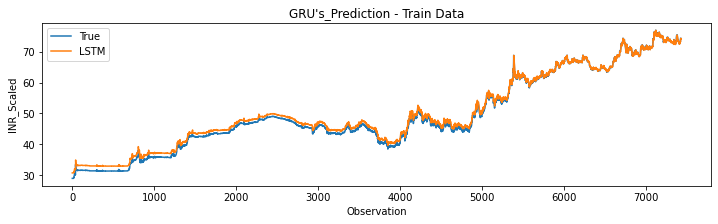

In [20]:
plt.figure(figsize=(12, 3))
plt.plot(iy_train, label='True')
plt.plot(y_train_pred_GRU, label='LSTM')
plt.title("GRU's_Prediction - Train Data")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

# Prediction the future data

In [21]:
# Extracting the data to be fed for future predictions

x_input=np.array(data3[len(data3)-size:]).reshape(1,size)
print(x_input.shape,'\n')
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(len(temp_input))
temp_input[:5]

(1, 1) 

1


[0.9597190366972478]

In [25]:
# demonstrate prediction for next 300 days
from numpy import array
print(len(temp_input))
output=[]
n_steps=size
i=0
while(i<300):
    
    if(len(temp_input)>size):
        x_input=np.array(temp_input[1:])
        x_input = x_input.reshape((1,1, n_steps))
        yhat = model_GRU.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape(1,1,n_steps)
        yhat = model_GRU.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        output.extend(yhat.tolist())
        i=i+1
    

print(output)

[[0.9587729573249817], [0.9578272700309753], [0.9568822979927063], [0.9559380412101746], [0.9549946784973145], [0.9540524482727051], [0.9531116485595703], [0.9521722793579102], [0.9512345790863037], [0.9502987265586853], [0.9493648409843445], [0.9484331011772156], [0.9475036263465881], [0.9465766549110413], [0.9456523656845093], [0.9447308778762817], [0.9438123106956482], [0.9428967833518982], [0.9419844746589661], [0.9410756230354309], [0.9401703476905823], [0.9392687082290649], [0.9383708834648132], [0.9374771118164062], [0.936587393283844], [0.935701847076416], [0.9348207116127014], [0.9339441061019897], [0.9330722689628601], [0.9322049617767334], [0.931342601776123], [0.9304853081703186], [0.9296330809593201], [0.928786039352417], [0.9279444217681885], [0.9271082282066345], [0.9262776374816895], [0.9254525899887085], [0.9246333837509155], [0.9238199591636658], [0.9230125546455383], [0.9222109317779541], [0.9214154481887817], [0.9206261038780212], [0.9198430776596069], [0.9190663099

# plotting the final predicted along side the previous values

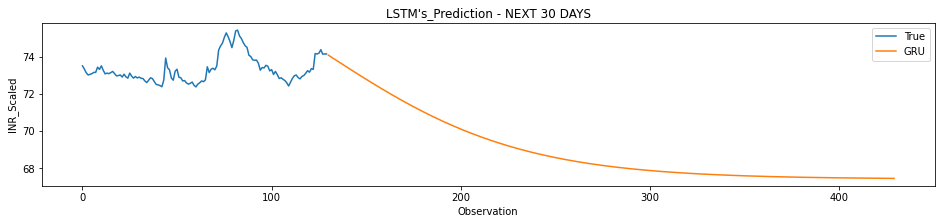

In [27]:

day_pred=np.arange(130,130+300)
plt.figure(figsize=(16, 3))
plt.plot(iy_train[7431-size-130:], label='True')
plt.plot(day_pred,scaler.inverse_transform(output), label='GRU')
plt.title("LSTM's_Prediction - NEXT 30 DAYS")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [28]:
print('PREDICTED VALUES FOR NEXT 300 DAYS')
print('--------------------------------\n')
result = scaler.inverse_transform(output)
# for i in range(len(lst_output)):
# for x in result:
#   print(x, sep = ', ' )
print(result)

PREDICTED VALUES FOR NEXT 300 DAYS
--------------------------------

[[74.0740015 ]
 [74.00803036]
 [73.94210911]
 [73.87623775]
 [73.81042877]
 [73.74469879]
 [73.6790686 ]
 [73.61353821]
 [73.54812424]
 [73.48283916]
 [73.41769131]
 [73.35269314]
 [73.28785297]
 [73.22318745]
 [73.15870903]
 [73.09442604]
 [73.03034679]
 [72.96647961]
 [72.90283695]
 [72.83943546]
 [72.77628345]
 [72.71338509]
 [72.65075283]
 [72.58840332]
 [72.52633656]
 [72.46456085]
 [72.40309284]
 [72.34194084]
 [72.28112148]
 [72.22061813]
 [72.1604599 ]
 [72.1006551 ]
 [72.04120373]
 [71.98211411]
 [71.92340286]
 [71.86507   ]
 [71.80712799]
 [71.74957268]
 [71.69242485]
 [71.63568035]
 [71.57935581]
 [71.5234346 ]
 [71.46794167]
 [71.41287701]
 [71.3582531 ]
 [71.30406578]
 [71.25032337]
 [71.19703419]
 [71.14419823]
 [71.09181133]
 [71.03989845]
 [70.98844711]
 [70.93746563]
 [70.886954  ]
 [70.83691639]
 [70.78735695]
 [70.73827984]
 [70.68967258]
 [70.64155182]
 [70.59392586]
 [70.54678223]
 [70.50012924]
 